In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv = 300
conn_prob = 1

In [3]:
peak_rate, kernel_width = 150, 10

In [4]:
T_rend = 100 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(1, N_Aiv))
# ( 1, Number of renditions )
burst_ts = np.array([[T_rend * (j + 1/2) for j in range(N_rend)]])
save_W_ts = (burst_ts[0] + T_rend / 2 - 1).astype(int) # [0] to squeeze

In [6]:
_ = rng.standard_normal((1, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = np.tile(syl, (T, 1))

In [8]:
rmax, s, th = 100, 1, 4
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1, 0.1
JEE, JEI, JIE, JII = np.array([1, 2, 1, 0.5]) * 0.3
tau_Aiv, tau_I, dt = 20, 10, 1

net = Aiv(N_Aiv, 1, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
          tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.1, ext_I, bilin_hebb,
            lr=-5e-7, w0_mean=w0_mean, tau_w=5e7)
rA, rI, Ws, mean_HVC_input = _

[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

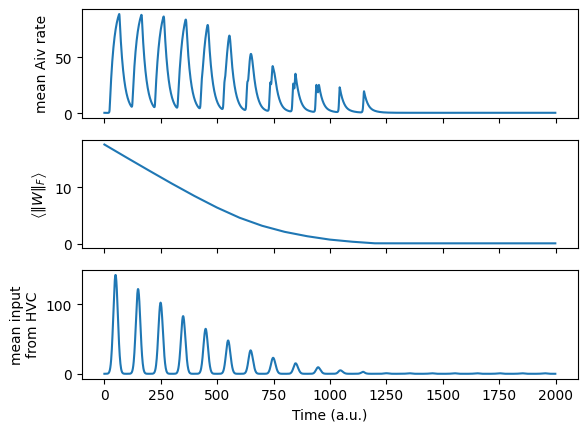

In [11]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [12]:
W_syl_corrs = [correlation(_.T, syl) for _ in Ws]

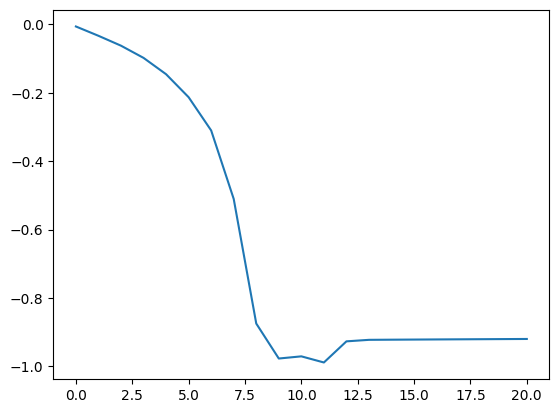

In [13]:
plt.plot(list(map(lambda x: x.flatten(), W_syl_corrs)))

0.7647263682042887

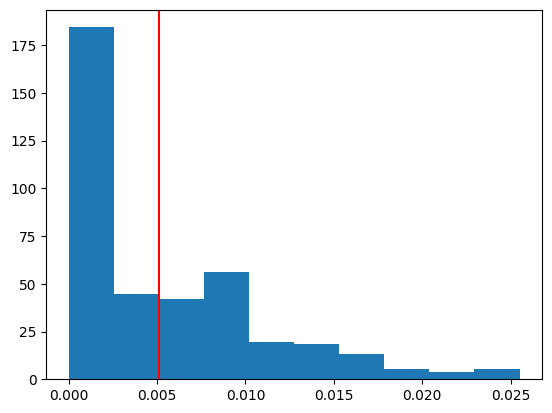

In [14]:
plt.hist(Ws[-1].flatten(), density=True, bins=10)
plt.axvline(Ws[-1].mean(), color='r')
# plt.axvline(w0_mean, color='k')
Ws[-1].mean() * peak_rate

In [15]:
dt = 0.1
def noisy_input(eps0, sig, tau, repeat, rH=peak_rate, _T_rend = 5000):
    rA = np.zeros((repeat, _T_rend, N_Aiv))
    rI = np.zeros((repeat, _T_rend))
    
    rH_ = np.zeros((_T_rend, 1)) + rH
    
    aud = np.tile(syl, (_T_rend, 1))
    noise = np.zeros((repeat, _T_rend, N_Aiv))
    for i in tqdm(range(repeat)):
        Aiv0, I0 = rng.random(N_Aiv), 1
        noise[i,0] = eps0
        for t in range(1, _T_rend):
            dn = (-noise[i,t-1] + eps0 + rng.normal(scale=sig, size=N_Aiv)) / tau
            noise[i,t] = noise[i,t-1] + dn * dt
    
        rA[i], rI[i] = net.sim(Aiv0, I0, rH_, aud+noise[i], [], 
                               _T_rend, dt, 0, ext_I)[:2]
    ts = np.arange(0, _T_rend*0.1, 0.1)
    return ts, rA, rI, noise

## Zero mean, low fluctuation

In [16]:
ts, rA, rI, noise = noisy_input(0, 10, 30, repeat=30)

100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]


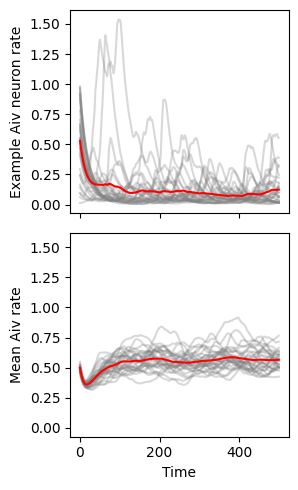

In [17]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

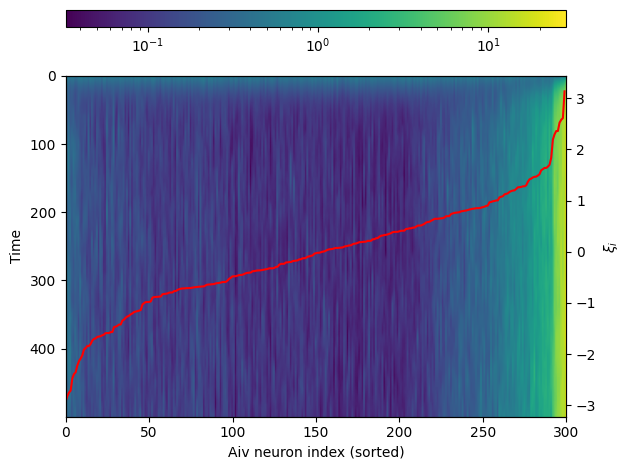

In [18]:
fig, (cax, ax) = plt.subplots(2, gridspec_kw=dict(height_ratios=[1, 20]))
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
im = ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
                  extent=[0, N_Aiv, *ts[[-1,0]]], norm='log')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')
fig.tight_layout()

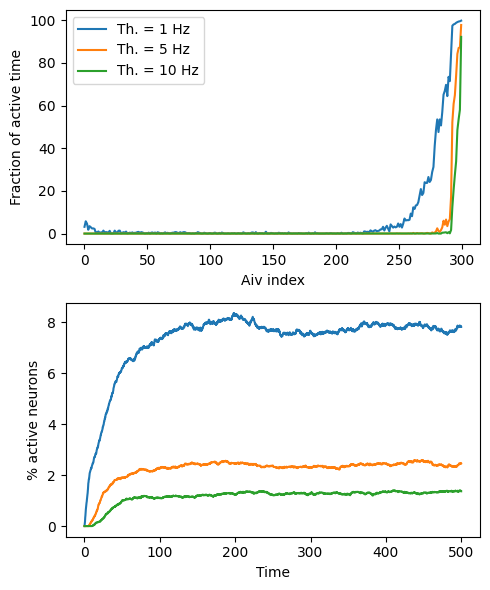

In [19]:
ths = (1, 5, 10)
fig, ax = plt.subplots(2, figsize=(5, 6))
idx = np.argsort(syl[0])
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=1).T / rA.shape[1]
    s2 = (rA > _).sum(axis=2).T / N_Aiv
    ax[0].plot(s1.mean(axis=1)[idx] * 100, label='Th. = %d Hz' % _)
    ax[1].plot(ts, s2.mean(axis=1) * 100, label='Th. = %d Hz' % _)
ax[0].set(xlabel='Aiv index', ylabel='Fraction of active time')
ax[1].set(xlabel='Time', ylabel='% active neurons')
ax[0].legend()
fig.tight_layout()

Text(0, 0.5, 'Density')

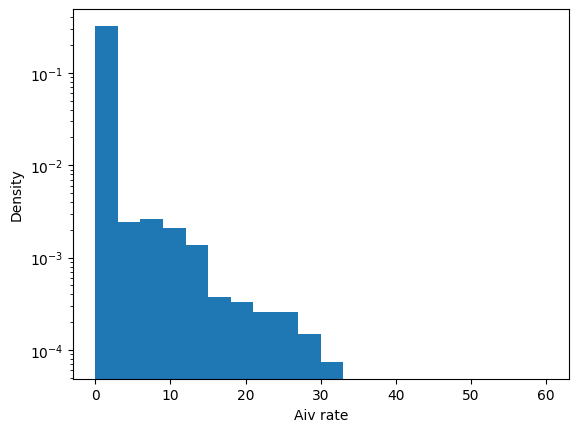

In [20]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 60), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')

In [21]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
# cross-correlation between rA_i and noise_i
cc_An = np.zeros((rA.shape[0], rA.shape[1]//step*2-1, N_Aiv)) 
cc0_AA = np.zeros((rA.shape[0], N_Aiv, N_Aiv)) # Zero lag pairwise cross-correlation
# Temporal pairwise correlation
# corr_t_AA = np.zeros((rA.shape[1]//step, N_Aiv, N_Aiv)) 
rA_ = rA[:,::step,:]
rA0 = (rA_ - rA_.mean(axis=0, keepdims=True)) / rA_.std(axis=0, keepdims=True)
rA1 = (rA_ - rA_.mean(axis=1, keepdims=True)) / rA_.std(axis=1, keepdims=True)
aux = noise[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for j in tqdm(range(N_Aiv)):
    for k in range(j,N_Aiv):
        cc0_AA[:,j,k] = (rA1[...,j] * rA1[...,k]).mean(axis=1)
        cc0_AA[:,k,j] = cc0_AA[:,j,k]

        # corr_t_AA[:,j,k] = (rA0[...,j] * rA0[...,k]).mean(axis=0)
        # corr_t_AA[:,k,j] = corr_t_AA[:,j,k]
    
    for i in range(rA.shape[0]):
        ac_A[i,:,j] = np.correlate(rA1[i,:,j], rA1[i,:,j], mode='full')[rA1.shape[1]-1:]
        cc_An[i,:,j] = np.correlate(rA1[i,:,j], aux[i,:,j], mode='full')
# del rA_, aux
ac_A /= ac_A.shape[1]
cc_An /= cc_An.shape[1]

100%|███████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 107.94it/s]


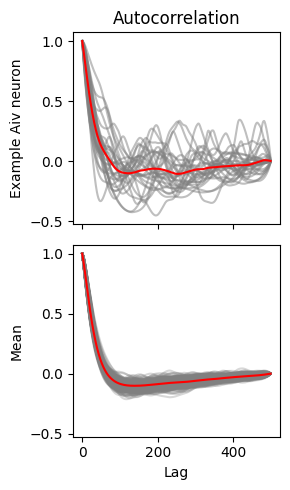

In [22]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Mean')
fig.tight_layout()

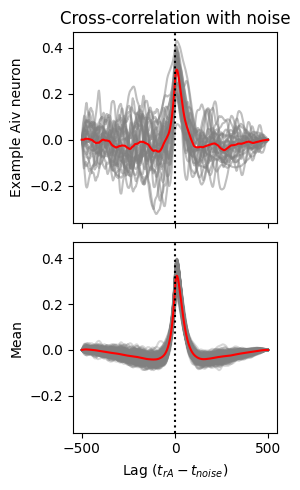

In [23]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
lags = np.arange(-(cc_An.shape[1]//2), cc_An.shape[1]//2+1)
ax[0].plot(lags, cc_An[...,0].T, c='grey', alpha=0.5)
ax[0].plot(lags, cc_An[...,0].mean(axis=0), c='r')
ax[1].plot(lags, cc_An.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(lags, cc_An.mean(axis=(0,-1)), c='r')
ax[0].axvline(0, ls=':', c='k')
ax[1].axvline(0, ls=':', c='k')
ax[0].set(title='Cross-correlation with noise', ylabel='Example Aiv neuron')
ax[1].set(xlabel=r'Lag ($t_{rA} - t_{noise}$)', ylabel='Mean')
fig.tight_layout()

/home/zg93/Projects/Aiv-Network/models.py:135: RuntimeWarning: invalid value encountered in divide
  sig2 = (sig2 - sig2.mean(axis=-1, keepdims=True)) / sig2.std(axis=-1, keepdims=True)


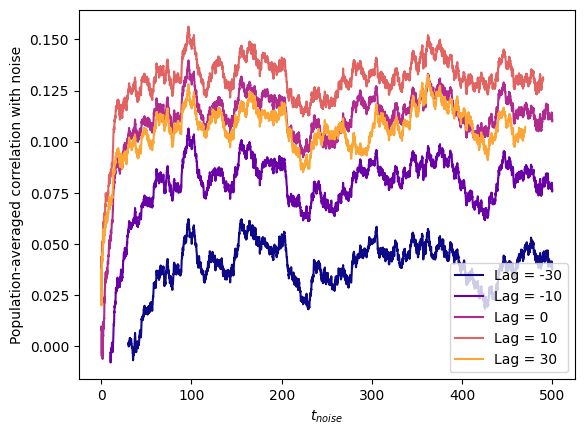

In [24]:
fig, ax = plt.subplots(1)
cmap = colormaps.get_cmap('plasma')
for i, lag in enumerate((-300, -100, 0, 100, 300)):
    rA_ = rA[:,max(lag, 0):min(rA.shape[1]+lag, rA.shape[1])]
    n_ = noise[:,max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])]
    ax.plot(ts[max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])], 
            correlation(rA_, n_, dim=1).mean(axis=0),
            label='Lag = %d' % (lag * dt), c=cmap(i/5))
ax.set(xlabel=r'$t_{noise}$', ylabel='Population-averaged correlation with noise')
ax.legend()

/tmp/ipykernel_20005/2450017378.py:2: RuntimeWarning: divide by zero encountered in divide
  nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))


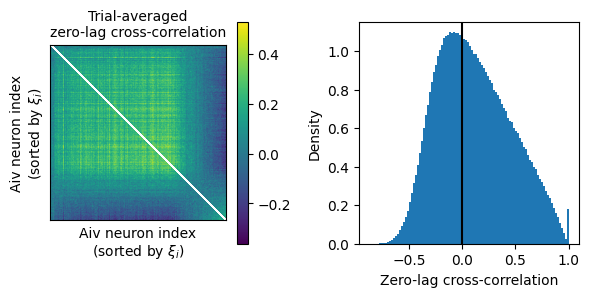

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))
idx = np.argsort(syl[0])
ta_cc0_AA = (cc0_AA.mean(axis=0) + nan_mask)[idx,:][:,idx]
im = ax[0].imshow(ta_cc0_AA)
# ax[0].set_axis_off()
ax[0].set(xlabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', xticks=[], 
          ylabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', yticks=[])
ax[0].set_title('Trial-averaged\nzero-lag cross-correlation', fontsize=10)
fig.colorbar(im)
ax[1].hist(cc0_AA.flatten(), bins=100, density=True)
ax[1].axvline(0, c='k')
ax[1].set(xlabel='Zero-lag cross-correlation', ylabel='Density')
fig.tight_layout()

## Zero mean, intermediate fluctuation

In [26]:
ts, rA, rI, noise = noisy_input(0, 17, 30, repeat=30)

100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]


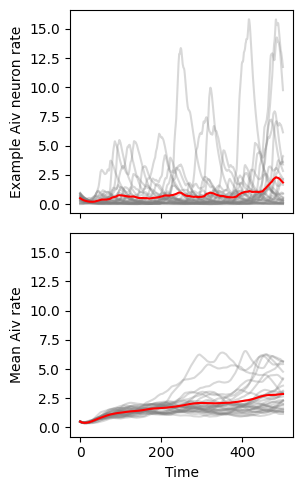

In [27]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

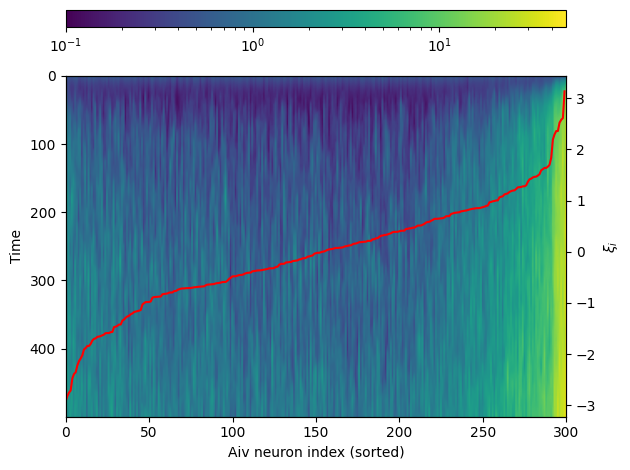

In [28]:
fig, (cax, ax) = plt.subplots(2, gridspec_kw=dict(height_ratios=[1, 20]))
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
im = ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
                  extent=[0, N_Aiv, *ts[[-1,0]]], norm='log')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')
fig.tight_layout()

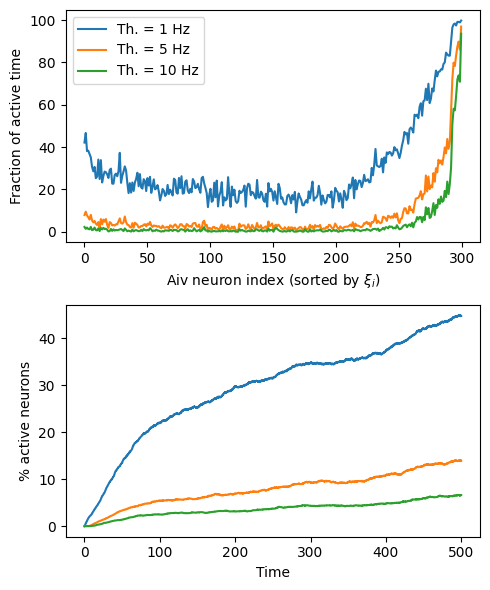

In [29]:
ths = (1, 5, 10)
fig, ax = plt.subplots(2, figsize=(5, 6))
idx = np.argsort(syl[0])
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=1).T / rA.shape[1]
    s2 = (rA > _).sum(axis=2).T / N_Aiv
    ax[0].plot(s1.mean(axis=1)[idx] * 100, label='Th. = %d Hz' % _)
    ax[1].plot(ts, s2.mean(axis=1) * 100, label='Th. = %d Hz' % _)
ax[0].set(xlabel=r'Aiv neuron index (sorted by $\xi_i$)', ylabel='Fraction of active time')
ax[1].set(xlabel='Time', ylabel='% active neurons')
ax[0].legend()
fig.tight_layout()

Text(0, 0.5, 'Density')

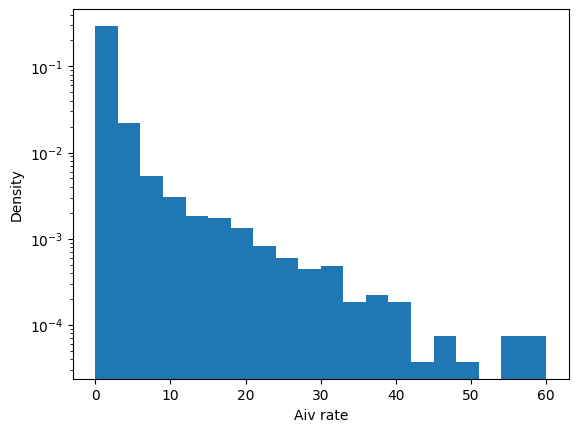

In [30]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 60), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')

In [31]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
# cross-correlation between rA_i and noise_i
cc_An = np.zeros((rA.shape[0], rA.shape[1]//step*2-1, N_Aiv)) 
cc0_AA = np.zeros((rA.shape[0], N_Aiv, N_Aiv)) # Zero lag pairwise cross-correlation
# Temporal pairwise correlation
# corr_t_AA = np.zeros((rA.shape[1]//step, N_Aiv, N_Aiv)) 
rA_ = rA[:,::step,:]
rA0 = (rA_ - rA_.mean(axis=0, keepdims=True)) / rA_.std(axis=0, keepdims=True)
rA1 = (rA_ - rA_.mean(axis=1, keepdims=True)) / rA_.std(axis=1, keepdims=True)
aux = noise[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for j in tqdm(range(N_Aiv)):
    for k in range(j,N_Aiv):
        cc0_AA[:,j,k] = (rA1[...,j] * rA1[...,k]).mean(axis=1)
        cc0_AA[:,k,j] = cc0_AA[:,j,k]

        # corr_t_AA[:,j,k] = (rA0[...,j] * rA0[...,k]).mean(axis=0)
        # corr_t_AA[:,k,j] = corr_t_AA[:,j,k]
    
    for i in range(rA.shape[0]):
        ac_A[i,:,j] = np.correlate(rA1[i,:,j], rA1[i,:,j], mode='full')[rA1.shape[1]-1:]
        cc_An[i,:,j] = np.correlate(rA1[i,:,j], aux[i,:,j], mode='full')
# del rA_, aux
ac_A /= ac_A.shape[1]
cc_An /= cc_An.shape[1]

100%|███████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.36it/s]


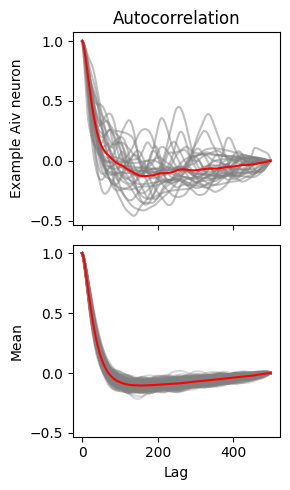

In [32]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Mean')
fig.tight_layout()

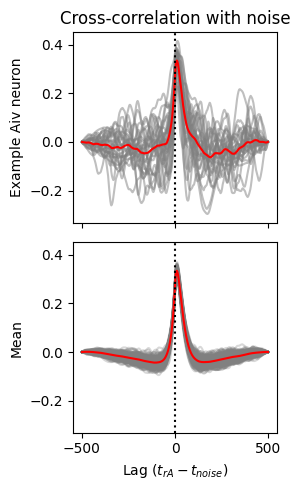

In [33]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
lags = np.arange(-(cc_An.shape[1]//2), cc_An.shape[1]//2+1)
ax[0].plot(lags, cc_An[...,0].T, c='grey', alpha=0.5)
ax[0].plot(lags, cc_An[...,0].mean(axis=0), c='r')
ax[1].plot(lags, cc_An.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(lags, cc_An.mean(axis=(0,-1)), c='r')
ax[0].axvline(0, ls=':', c='k')
ax[1].axvline(0, ls=':', c='k')
ax[0].set(title='Cross-correlation with noise', ylabel='Example Aiv neuron')
ax[1].set(xlabel=r'Lag ($t_{rA} - t_{noise}$)', ylabel='Mean')
fig.tight_layout()

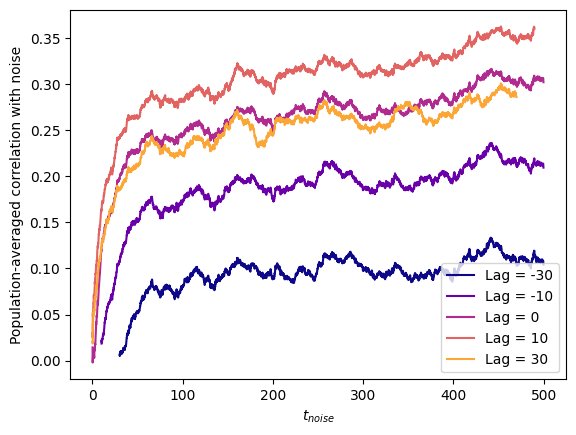

In [34]:
fig, ax = plt.subplots(1)
cmap = colormaps.get_cmap('plasma')
for i, lag in enumerate((-300, -100, 0, 100, 300)):
    rA_ = rA[:,max(lag, 0):min(rA.shape[1]+lag, rA.shape[1])]
    n_ = noise[:,max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])]
    ax.plot(ts[max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])], 
            correlation(rA_, n_, dim=1).mean(axis=0),
            label='Lag = %d' % (lag * dt), c=cmap(i/5))
ax.set(xlabel=r'$t_{noise}$', ylabel='Population-averaged correlation with noise')
ax.legend()

/tmp/ipykernel_20005/2450017378.py:2: RuntimeWarning: divide by zero encountered in divide
  nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))


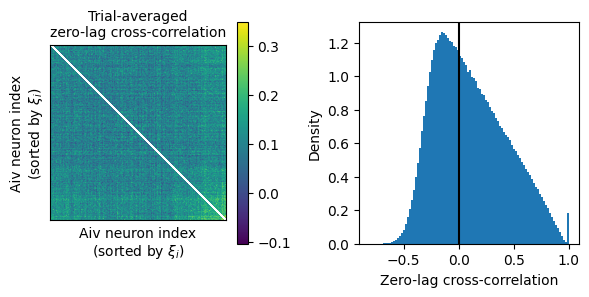

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))
idx = np.argsort(syl[0])
ta_cc0_AA = (cc0_AA.mean(axis=0) + nan_mask)[idx,:][:,idx]
im = ax[0].imshow(ta_cc0_AA)
# ax[0].set_axis_off()
ax[0].set(xlabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', xticks=[], 
          ylabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', yticks=[])
ax[0].set_title('Trial-averaged\nzero-lag cross-correlation', fontsize=10)
fig.colorbar(im)
ax[1].hist(cc0_AA.flatten(), bins=100, density=True)
ax[1].axvline(0, c='k')
ax[1].set(xlabel='Zero-lag cross-correlation', ylabel='Density')
fig.tight_layout()

## Zero mean, high fluctuation

In [36]:
ts, rA, rI, noise = noisy_input(0, 20, 30, repeat=30)

100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.16it/s]


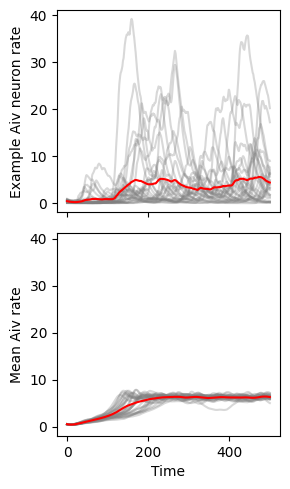

In [37]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

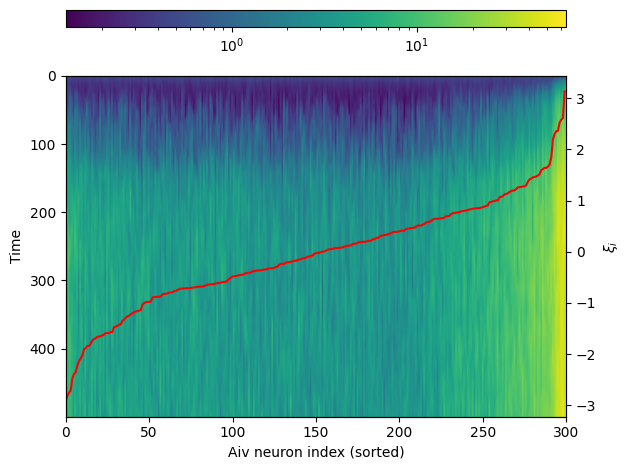

In [38]:
fig, (cax, ax) = plt.subplots(2, gridspec_kw=dict(height_ratios=[1, 20]))
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
im = ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
                  extent=[0, N_Aiv, *ts[[-1,0]]], norm='log')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')
fig.tight_layout()

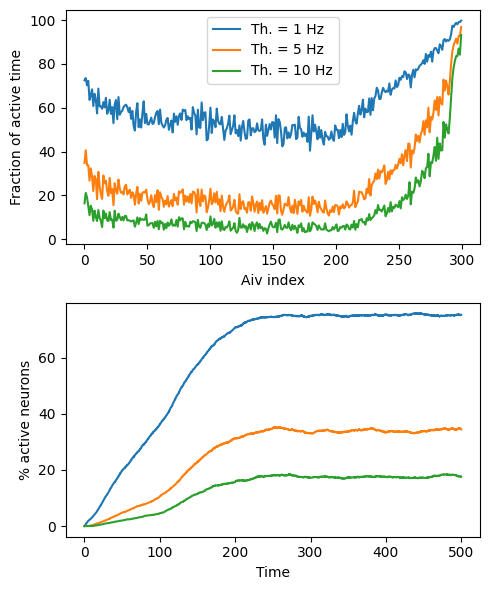

In [39]:
ths = (1, 5, 10)
fig, ax = plt.subplots(2, figsize=(5, 6))
idx = np.argsort(syl[0])
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=1).T / rA.shape[1]
    s2 = (rA > _).sum(axis=2).T / N_Aiv
    ax[0].plot(s1.mean(axis=1)[idx] * 100, label='Th. = %d Hz' % _)
    ax[1].plot(ts, s2.mean(axis=1) * 100, label='Th. = %d Hz' % _)
ax[0].set(xlabel='Aiv index', ylabel='Fraction of active time')
ax[1].set(xlabel='Time', ylabel='% active neurons')
ax[0].legend()
fig.tight_layout()

Text(0, 0.5, 'Density')

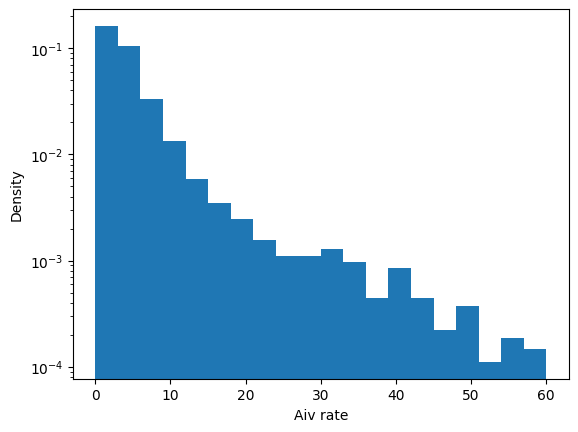

In [40]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 60), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')

In [41]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
# cross-correlation between rA_i and noise_i
cc_An = np.zeros((rA.shape[0], rA.shape[1]//step*2-1, N_Aiv)) 
cc0_AA = np.zeros((rA.shape[0], N_Aiv, N_Aiv)) # Zero lag pairwise cross-correlation
# Temporal pairwise correlation
# corr_t_AA = np.zeros((rA.shape[1]//step, N_Aiv, N_Aiv)) 
rA_ = rA[:,::step,:]
rA0 = (rA_ - rA_.mean(axis=0, keepdims=True)) / rA_.std(axis=0, keepdims=True)
rA1 = (rA_ - rA_.mean(axis=1, keepdims=True)) / rA_.std(axis=1, keepdims=True)
aux = noise[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for j in tqdm(range(N_Aiv)):
    for k in range(j,N_Aiv):
        cc0_AA[:,j,k] = (rA1[...,j] * rA1[...,k]).mean(axis=1)
        cc0_AA[:,k,j] = cc0_AA[:,j,k]

        # corr_t_AA[:,j,k] = (rA0[...,j] * rA0[...,k]).mean(axis=0)
        # corr_t_AA[:,k,j] = corr_t_AA[:,j,k]
    
    for i in range(rA.shape[0]):
        ac_A[i,:,j] = np.correlate(rA1[i,:,j], rA1[i,:,j], mode='full')[rA1.shape[1]-1:]
        cc_An[i,:,j] = np.correlate(rA1[i,:,j], aux[i,:,j], mode='full')
# del rA_, aux
ac_A /= ac_A.shape[1]
cc_An /= cc_An.shape[1]

100%|███████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 105.12it/s]


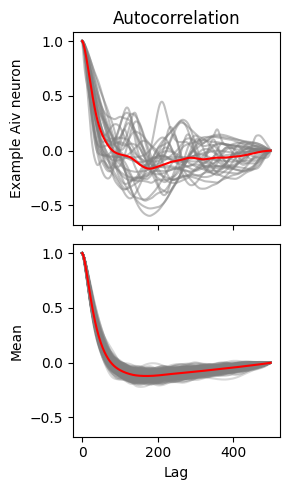

In [42]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Mean')
fig.tight_layout()

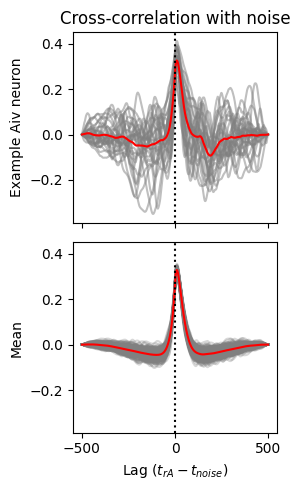

In [43]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
lags = np.arange(-(cc_An.shape[1]//2), cc_An.shape[1]//2+1)
ax[0].plot(lags, cc_An[...,0].T, c='grey', alpha=0.5)
ax[0].plot(lags, cc_An[...,0].mean(axis=0), c='r')
ax[1].plot(lags, cc_An.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(lags, cc_An.mean(axis=(0,-1)), c='r')
ax[0].axvline(0, ls=':', c='k')
ax[1].axvline(0, ls=':', c='k')
ax[0].set(title='Cross-correlation with noise', ylabel='Example Aiv neuron')
ax[1].set(xlabel=r'Lag ($t_{rA} - t_{noise}$)', ylabel='Mean')
fig.tight_layout()

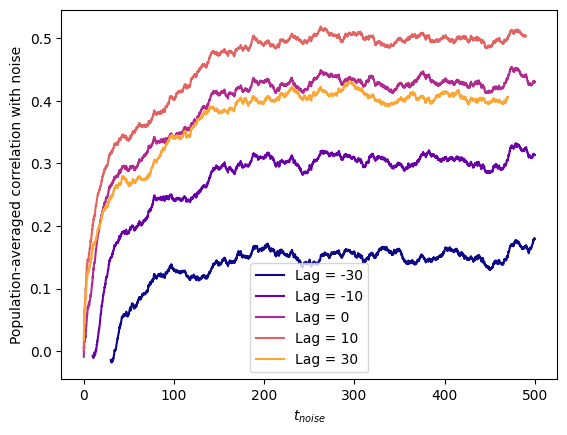

In [44]:
fig, ax = plt.subplots(1)
cmap = colormaps.get_cmap('plasma')
for i, lag in enumerate((-300, -100, 0, 100, 300)):
    rA_ = rA[:,max(lag, 0):min(rA.shape[1]+lag, rA.shape[1])]
    n_ = noise[:,max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])]
    ax.plot(ts[max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])], 
            correlation(rA_, n_, dim=1).mean(axis=0),
            label='Lag = %d' % (lag * dt), c=cmap(i/5))
ax.set(xlabel=r'$t_{noise}$', ylabel='Population-averaged correlation with noise')
ax.legend()

/tmp/ipykernel_20005/2450017378.py:2: RuntimeWarning: divide by zero encountered in divide
  nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))


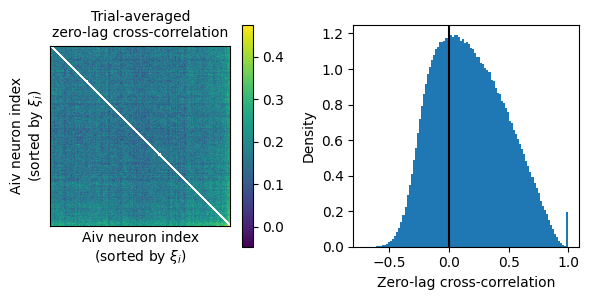

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))
idx = np.argsort(syl[0])
ta_cc0_AA = (cc0_AA.mean(axis=0) + nan_mask)[idx,:][:,idx]
im = ax[0].imshow(ta_cc0_AA)
# ax[0].set_axis_off()
ax[0].set(xlabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', xticks=[], 
          ylabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', yticks=[])
ax[0].set_title('Trial-averaged\nzero-lag cross-correlation', fontsize=10)
fig.colorbar(im)
ax[1].hist(cc0_AA.flatten(), bins=100, density=True)
ax[1].axvline(0, c='k')
ax[1].set(xlabel='Zero-lag cross-correlation', ylabel='Density')
fig.tight_layout()

## Positive mean, low fluctuation

In [46]:
ts, rA, rI, noise = noisy_input(0.5, 10, 30, repeat=30)

100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.20it/s]


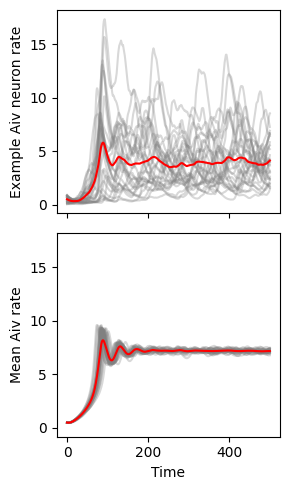

In [47]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ts, rA[...,0].T, c='grey', alpha=0.3)
ax[0].plot(ts, rA[...,0].mean(axis=0), c='r')
ax[0].set(ylabel='Example Aiv neuron rate')
ax[1].plot(ts, rA.mean(axis=-1).T, c='grey', alpha=0.3)
ax[1].plot(ts, rA.mean(axis=(0,-1)), c='r') 
ax[1].set(ylabel='Mean Aiv rate', xlabel='Time')
fig.tight_layout()

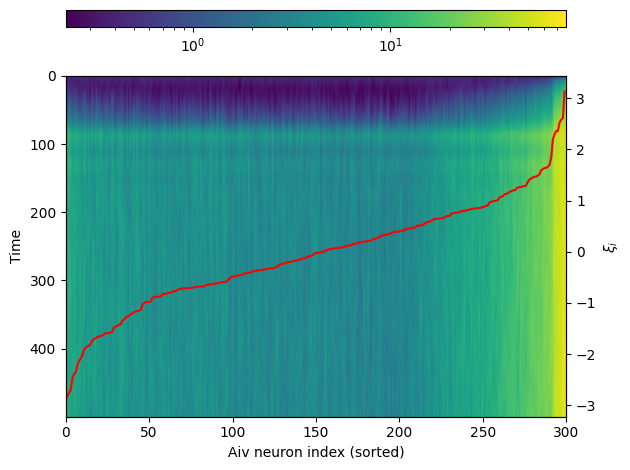

In [48]:
fig, (cax, ax) = plt.subplots(2, gridspec_kw=dict(height_ratios=[1, 20]))
ax = [ax, ax.twinx()]
idx = np.argsort(syl[0])
im = ax[0].imshow(rA[:, ::10, idx].mean(axis=0), aspect='auto',
                  extent=[0, N_Aiv, *ts[[-1,0]]], norm='log')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax[0].set(xlabel='Aiv neuron index (sorted)', ylabel='Time')
ax[1].plot(np.arange(N_Aiv), syl[0,idx], c='r')
ax[1].set_ylabel(r'$\xi_i$')
fig.tight_layout()

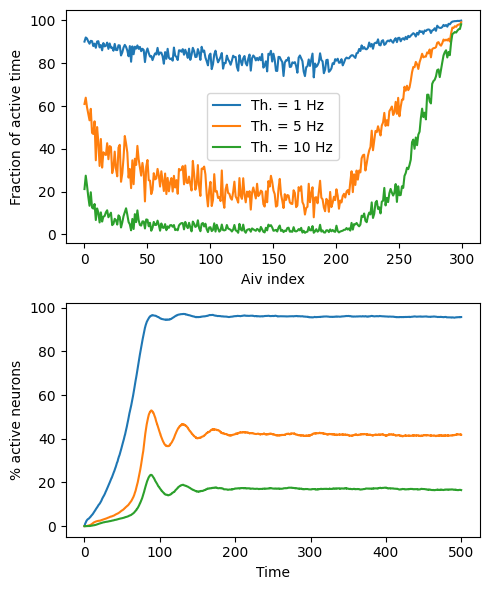

In [49]:
ths = (1, 5, 10)
fig, ax = plt.subplots(2, figsize=(5, 6))
idx = np.argsort(syl[0])
for i, _ in enumerate(ths):
    s1 = (rA > _).sum(axis=1).T / rA.shape[1]
    s2 = (rA > _).sum(axis=2).T / N_Aiv
    ax[0].plot(s1.mean(axis=1)[idx] * 100, label='Th. = %d Hz' % _)
    ax[1].plot(ts, s2.mean(axis=1) * 100, label='Th. = %d Hz' % _)
ax[0].set(xlabel='Aiv index', ylabel='Fraction of active time')
ax[1].set(xlabel='Time', ylabel='% active neurons')
ax[0].legend()
fig.tight_layout()

Text(0, 0.5, 'Density')

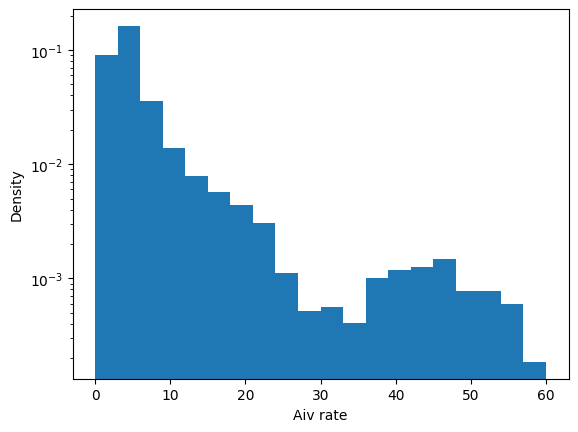

In [50]:
plt.hist(rA.mean(axis=1).flatten(), bins=20, range=(0, 60), density=True, log=True)
plt.xlabel('Aiv rate')
plt.ylabel('Density')

In [51]:
step = 10
ac_A = np.zeros((rA.shape[0], rA.shape[1]//step, N_Aiv))
# cross-correlation between rA_i and noise_i
cc_An = np.zeros((rA.shape[0], rA.shape[1]//step*2-1, N_Aiv)) 
cc0_AA = np.zeros((rA.shape[0], N_Aiv, N_Aiv)) # Zero lag pairwise cross-correlation
# Temporal pairwise correlation
# corr_t_AA = np.zeros((rA.shape[1]//step, N_Aiv, N_Aiv)) 
rA_ = rA[:,::step,:]
rA0 = (rA_ - rA_.mean(axis=0, keepdims=True)) / rA_.std(axis=0, keepdims=True)
rA1 = (rA_ - rA_.mean(axis=1, keepdims=True)) / rA_.std(axis=1, keepdims=True)
aux = noise[:,::step,:]
aux = (aux - aux.mean(axis=1, keepdims=True)) / aux.std(axis=1, keepdims=True)
for j in tqdm(range(N_Aiv)):
    for k in range(j,N_Aiv):
        cc0_AA[:,j,k] = (rA1[...,j] * rA1[...,k]).mean(axis=1)
        cc0_AA[:,k,j] = cc0_AA[:,j,k]

        # corr_t_AA[:,j,k] = (rA0[...,j] * rA0[...,k]).mean(axis=0)
        # corr_t_AA[:,k,j] = corr_t_AA[:,j,k]
    
    for i in range(rA.shape[0]):
        ac_A[i,:,j] = np.correlate(rA1[i,:,j], rA1[i,:,j], mode='full')[rA1.shape[1]-1:]
        cc_An[i,:,j] = np.correlate(rA1[i,:,j], aux[i,:,j], mode='full')
# del rA_, aux
ac_A /= ac_A.shape[1]
cc_An /= cc_An.shape[1]

100%|███████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 107.05it/s]


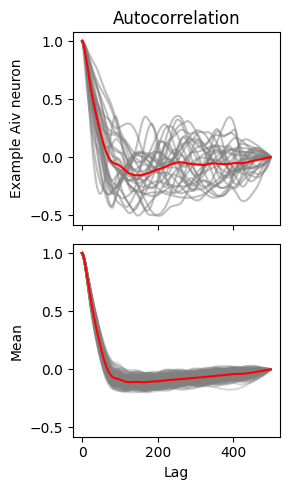

In [52]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
ax[0].plot(ac_A[...,0].T, c='grey', alpha=0.5)
ax[0].plot(ac_A[...,0].mean(axis=0), c='r')
ax[1].plot(ac_A.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(ac_A.mean(axis=(0,-1)), c='r')
ax[0].set(title='Autocorrelation', ylabel='Example Aiv neuron')
ax[1].set(xlabel='Lag', ylabel='Mean')
fig.tight_layout()

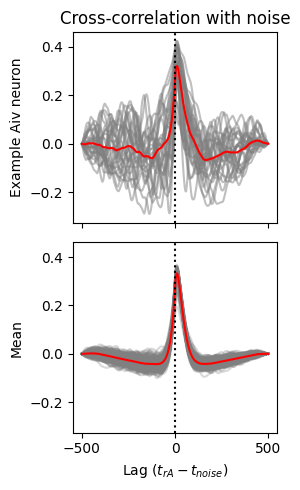

In [53]:
fig, ax = plt.subplots(2, sharey='all', sharex='all', figsize=(3, 5))
lags = np.arange(-(cc_An.shape[1]//2), cc_An.shape[1]//2+1)
ax[0].plot(lags, cc_An[...,0].T, c='grey', alpha=0.5)
ax[0].plot(lags, cc_An[...,0].mean(axis=0), c='r')
ax[1].plot(lags, cc_An.mean(axis=0), c='grey', alpha=0.3)
ax[1].plot(lags, cc_An.mean(axis=(0,-1)), c='r')
ax[0].axvline(0, ls=':', c='k')
ax[1].axvline(0, ls=':', c='k')
ax[0].set(title='Cross-correlation with noise', ylabel='Example Aiv neuron')
ax[1].set(xlabel=r'Lag ($t_{rA} - t_{noise}$)', ylabel='Mean')
fig.tight_layout()

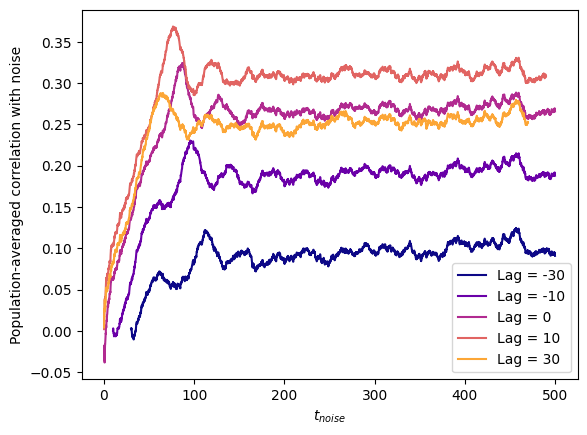

In [54]:
fig, ax = plt.subplots(1)
cmap = colormaps.get_cmap('plasma')
for i, lag in enumerate((-300, -100, 0, 100, 300)):
    rA_ = rA[:,max(lag, 0):min(rA.shape[1]+lag, rA.shape[1])]
    n_ = noise[:,max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])]
    ax.plot(ts[max(-lag, 0):min(rA.shape[1]-lag, rA.shape[1])], 
            correlation(rA_, n_, dim=1).mean(axis=0),
            label='Lag = %d' % (lag * dt), c=cmap(i/5))
ax.set(xlabel=r'$t_{noise}$', ylabel='Population-averaged correlation with noise')
ax.legend()

/tmp/ipykernel_20005/2450017378.py:2: RuntimeWarning: divide by zero encountered in divide
  nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))


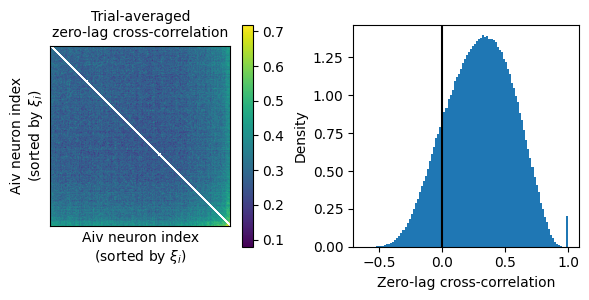

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
nan_mask = 1 - 1 / (1 - np.identity(N_Aiv))
idx = np.argsort(syl[0])
ta_cc0_AA = (cc0_AA.mean(axis=0) + nan_mask)[idx,:][:,idx]
im = ax[0].imshow(ta_cc0_AA)
# ax[0].set_axis_off()
ax[0].set(xlabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', xticks=[], 
          ylabel='Aiv neuron index\n' + r'(sorted by $\xi_i$)', yticks=[])
ax[0].set_title('Trial-averaged\nzero-lag cross-correlation', fontsize=10)
fig.colorbar(im)
ax[1].hist(cc0_AA.flatten(), bins=100, density=True)
ax[1].axvline(0, c='k')
ax[1].set(xlabel='Zero-lag cross-correlation', ylabel='Density')
fig.tight_layout()